## Chandrasekhar H-equation

$$F(H)(\mu)=H(\mu)-\left(1-\frac{c}{2}\int_0^1 \frac{\mu H(\nu)}{\mu+\nu}d\nu\right)^{-1}$$

Uniform discretization.

$$\int_0^{1} f(\mu) d\mu \approx \frac{1}{N} \sum_{j=1}^N f(\mu_j)$$

where $\mu_i=(i-\frac12)/N,i=1,\ldots,N$.

Initial condition $H(\mu) = 1$. 

We will use a number of methods to solve this problem:

- Newton's method

- Inexact Newton's method

- Fixed point iteration

- Broyden's method (one step update)

- Broyden's method (matrix update with limited memory)

- Anderson's method (limited memory)

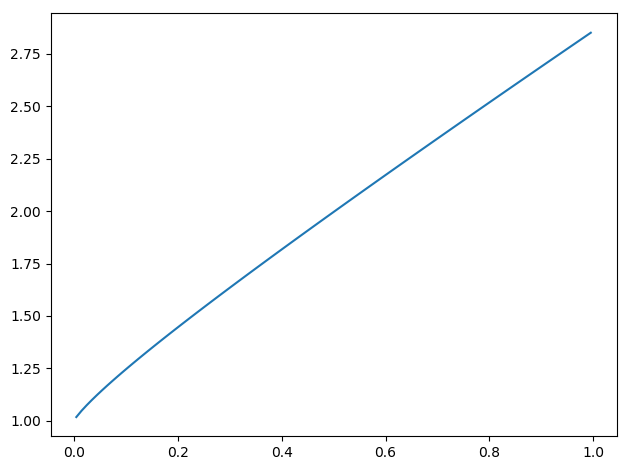

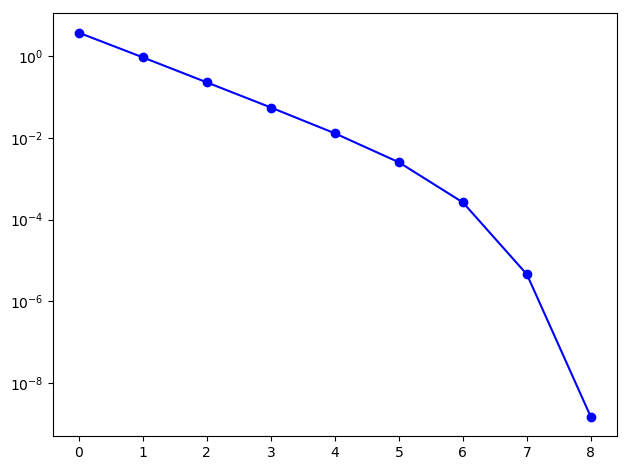

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f04be0a8470>

In [1]:
using LinearAlgebra

function CHfunc(x,mu,c; Jacobian="yes")
    N = length(x)
    F = zeros(N)
    for i = 1 : N
        F[i] = x[i] - 1 ./ (1-c/(2*N)*mu[i]*sum(x./(mu[i].+mu)))
    end
    if(Jacobian == "yes")
        J = Matrix(1.0I,N,N)
        for i = 1 : N
            fac = sum(x./(mu[i].+mu));
            for j = 1 : N
                J[i,j] += -(c/(2*N))*(mu[i]/(mu[i]+mu[j])) / (1-c/(2*N)*mu[i]*fac)^2
            end
        end
        return F,J
    else
        return F
    end
end    

# Solution by Newton method
N = 100
x = ones(Float64,N)
mu = ((1:N) .- 0.5)/N
c = 0.9999
maxiter = 10
tolnrmF = 1e-8
nrmF = zeros(maxiter)
iter_stop = maxiter
for iter = 1 : maxiter
    F,J=CHfunc(x,mu,c;Jacobian="yes")
    nrmF[iter] = norm(F)
    if( nrmF[iter] < tolnrmF )
        iter_stop = iter
        break 
    end
    x = x - J\F
end

xexact = x
using PyPlot
figure(1)
plot(mu,x)
figure(2)
semilogy(nrmF[1:iter_stop],"b-o")


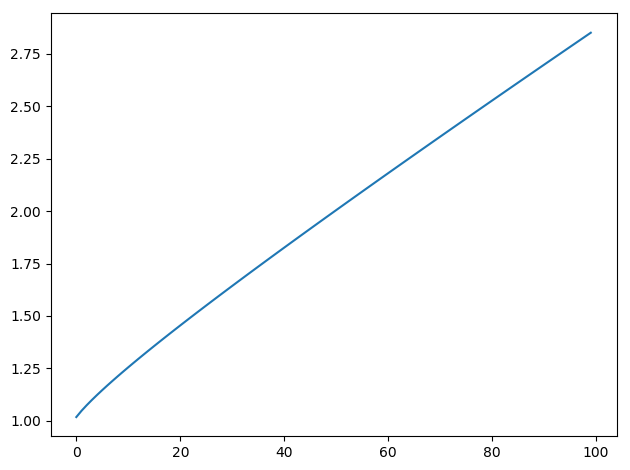

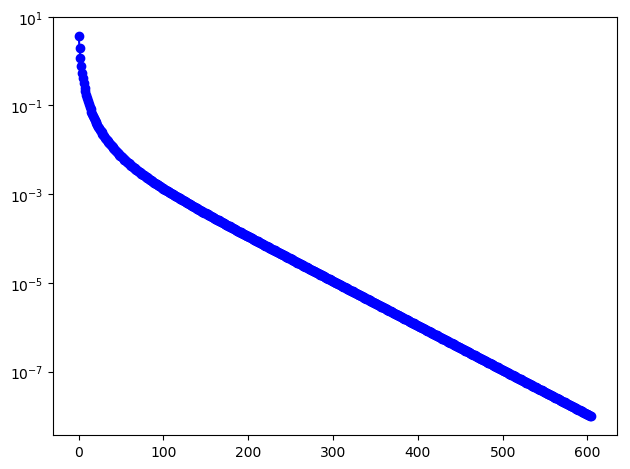

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f04bdfd0400>

In [2]:
# Fixed point iteration

x = ones(Float64,N)
maxiter = 1000
tolnrmF = 1e-8
nrmF = zeros(maxiter)
iter_stop = maxiter
for iter = 1 : maxiter
    F=CHfunc(x,mu,c;Jacobian="no")
    nrmF[iter] = norm(F)
    if( nrmF[iter] < tolnrmF )
        iter_stop = iter
        break 
    end
    x = x - F
end

using PyPlot
figure(1)
plot(x)
figure(2)
semilogy(nrmF[1:iter_stop],"b-o")

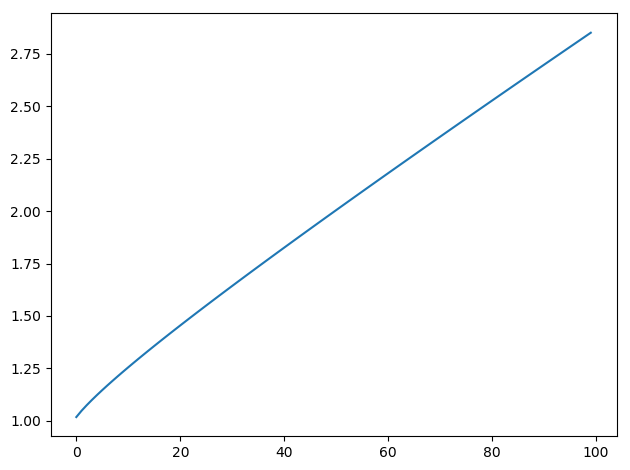

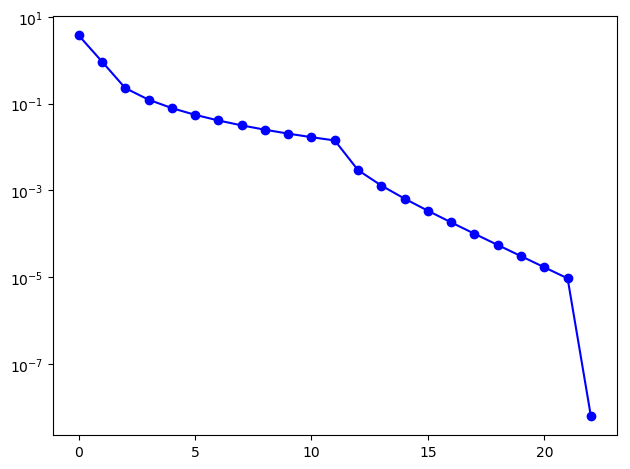

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f04bdd5a7f0>

In [10]:
# Variants of Newton's method. Fix J
let
    x = ones(Float64,N)
    maxiter = 1000
    tolnrmF = 1e-8
    nrmF = zeros(maxiter)
    Jfreq = 10
    iter_stop = maxiter
    F,J=CHfunc(x,mu,c;Jacobian="yes")

    for iter = 1 : maxiter
        if( mod(iter-1,Jfreq) == 1  )
            F,J=CHfunc(x,mu,c;Jacobian="yes")
        else
            F=CHfunc(x,mu,c;Jacobian="no")
        end
        nrmF[iter] = norm(F)
        if( nrmF[iter] < tolnrmF )
           iter_stop = iter
           break 
        end
        x = x - J\F
    end
    
    using PyPlot
    figure(1)
    plot(x)
    figure(2)
    semilogy(nrmF[1:iter_stop],"b-o")

end


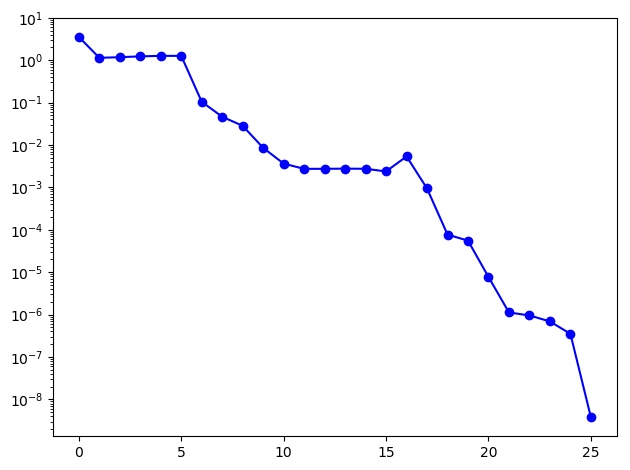

In [15]:
# Broyden's method
let
    x = ones(Float64,N)
    maxiter = 100
    tolnrmF = 1e-8
    nrmF = zeros(maxiter)


    alpha = 0.1
    B = alpha*Matrix(1.0I, N, N)
    
    
    xprv = x
    Fprv=CHfunc(xprv,mu,c;Jacobian="no")
    xcur = xprv - B*Fprv
    iter_stop = maxiter
    for iter = 1 : maxiter
        Fcur = CHfunc(xcur,mu,c;Jacobian="no")
        nrmF[iter] = norm(Fcur)
        if( norm(Fcur) < tolnrmF )
            iter_stop = iter
            break
        end
        s = xcur - xprv
        y = Fcur - Fprv
        B = B + 1.0/(dot(y,y))*(s-B*y)*y'
        xprv = xcur
        Fprv = Fcur
        xcur = xcur - B*Fcur
    end
    x = xcur
    
    using PyPlot

    semilogy(nrmF[1:iter_stop],"b-o")
end



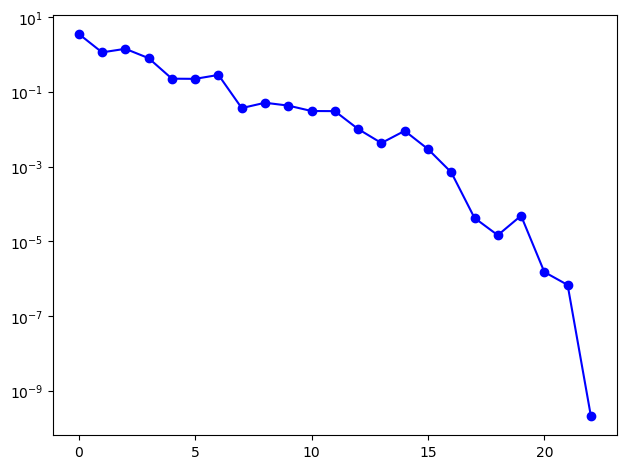

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f04b776fa90>

In [18]:
# Broyden's method. Matrix formulation. 
# This is an expensive implementation and only for demonstration purpose
# A better implementation should only store the needed part of the history of S, Y

let
    x = ones(Float64,N)
    maxiter = 100
    tolnrmF = 1e-8
    nrmF = zeros(maxiter)
    numhist = 4

    alpha = 0.10
    B = alpha*Matrix(1.0I,N,N)

    xprv = x
    Fprv=CHfunc(xprv,mu,c;Jacobian="no")
    xcur = xprv - B*Fprv
    S = zeros(N,maxiter) # This is the culprit for memory consumption
    Y = zeros(N,maxiter)
    iter_stop = maxiter
    for iter = 1 : maxiter
        Fcur = CHfunc(xcur,mu,c;Jacobian="no")
        nrmF[iter] = norm(Fcur)
        if( norm(Fcur) < tolnrmF )
            iter_stop = iter
            break
        end
        S[:,iter] = xcur - xprv
        Y[:,iter] = Fcur - Fprv
        ind = max(iter-numhist+1,1):iter

        av = S[:,ind] - B*Y[:,ind]
        bv = pinv(Y[:,ind],1e-12)
        B = B + av*bv
        xprv = xcur
        Fprv = Fcur
        xcur = xcur - B*Fcur
    end
    x = xcur
    using PyPlot
    # figure(1)
    # plot(x)
    figure(2)
    semilogy(nrmF[1:iter_stop],"b-o")
end

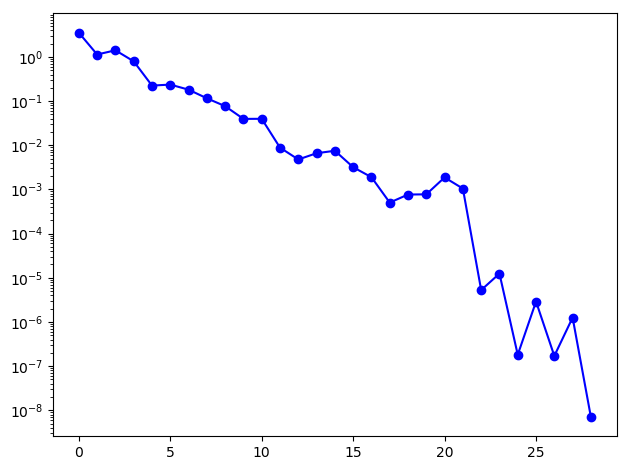

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f04b7d084e0>

In [20]:
# Anderson's method. Matrix formulation. 
# This is an expensive implementation and only for demonstration purpose
# A better implementation should only store the needed part of the history of S, Y

let
    x = ones(Float64,N)
    maxiter = 100
    tolnrmF = 1e-8
    nrmF = zeros(maxiter)
    numhist = 5

    alpha = 0.10
    B0 = alpha*Matrix(1.0I,N,N)
    B  = B0


    xprv = x
    Fprv=CHfunc(xprv,mu,c;Jacobian="no")
    xcur = xprv - B*Fprv
    S = zeros(N,maxiter)
    Y = zeros(N,maxiter)
    iter_stop=maxiter
    for iter = 1 : maxiter
        Fcur = CHfunc(xcur,mu,c;Jacobian="no")
        nrmF[iter] = norm(Fcur)
        if( norm(Fcur) < tolnrmF )
            iter_stop=iter
            break
        end
        S[:,iter] = xcur - xprv
        Y[:,iter] = Fcur - Fprv
        indhist = max(iter-numhist+1,1):iter
        gv = pinv(Y[:,indhist],1e-10)*Fcur
        xprv = xcur
        Fprv = Fcur
        xcur = xcur - S[:,indhist]*gv - B0*(Fcur-Y[:,indhist]*gv)
    end
    x = xcur
    using PyPlot
    # figure(1)
    # plot(x)
    figure(2)
    semilogy(nrmF[1:iter_stop],"b-o")
end